Solaris installation with gdal\
!add-apt-repository ppa:ubuntugis/ppa -y\
!apt-get update\
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [ ]:
!pip3 install torch torchvision

In [ ]:
!pip3 install py7zr

In [ ]:
!pip3 install rasterio

Solaris installation

In [ ]:
!add-apt-repository ppa:ubuntugis/ppa -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [ ]:
import torch
import rasterio
import py7zr
import os
import numpy as np
import pandas as pd
import solaris as sol
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torchvision import datasets, transforms, models

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

load dataset from github\
repo path : https://github.com/AnupamaRajkumar/LandfillDataset.git


In [ ]:
!git clone https://github.com/AnupamaRajkumar/LandfillDataset.git

Declaring paths

In [8]:
in_path = './LandfillDataset/Multispectral.7z'     #path of zip files
TIF_file_path = './Multispectral/HR_TIF_Files.7z'
JSON_file_path = './Multispectral/LandfillCoordPolygons.7z'
out_path = './'                                   #output path of extracted files
train_path = './HR_TIF_Files'
train_labels = './Multispectral/MultiSpectralData.csv'
json_path = './PerImagePolygonCoords'

width = 15
height = 15

Extract the imaages from zip folder

In [9]:
def ExtractFiles(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

In [10]:
#Extract the dataset folder
ExtractFiles(in_path, out_path)
#extract images
ExtractFiles(TIF_file_path , out_path)
#extract json files
ExtractFiles(JSON_file_path , out_path)

Displaying a few images from the folder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of training images: 53
-------------multispectral images----------------
(512, 512)
image :  00052_Vinca_Serbia.tif channels : 8
(512, 512)
image :  00049_Vinca_Serbia.tif channels : 8
(512, 512)
image :  00022_Abd_India.tif channels : 4
(512, 512)
image :  00019_Hanover_Germany.tif channels : 8
(512, 512)
image :  00033_Nurnberg_Germany.tif channels : 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)
image :  00007_Erd_Hungary.tif channels : 8


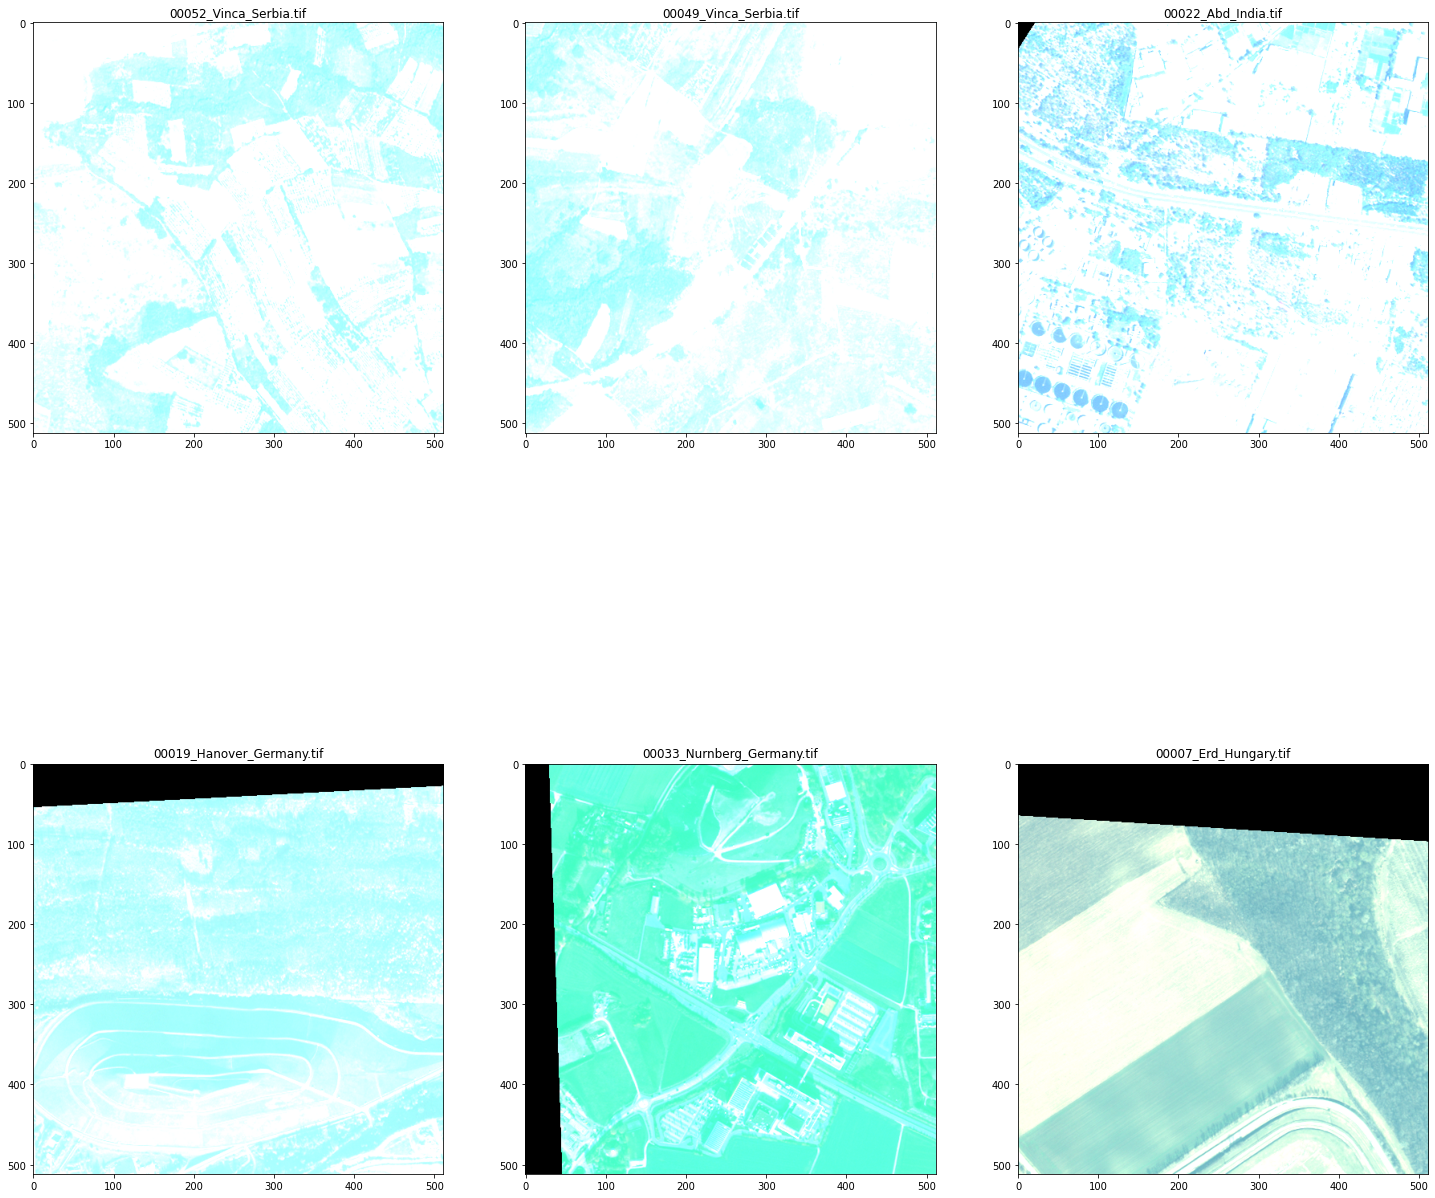

In [11]:
train_files = os.listdir(train_path)

num_of_train_images = len([name for name in train_files if os.path.isfile(os.path.join(train_path, name))])
print("Number of training images:", num_of_train_images)
selected = np.random.choice(num_of_train_images, 6)

fig = plt.figure(figsize = (25,25))
print('-------------multispectral images----------------')

for i, ind in enumerate(selected):
  raster = rasterio.open(os.path.join(train_path, train_files[ind]))
  print(raster.shape)
  raster_arr = raster.read()
  channels = raster_arr.shape[0]
  print("image : " , train_files[ind], "channels :", channels)
  #false color composite visualisation
  if(channels == 8):
    raster_fcc=np.dstack((raster_arr[4,:,:], raster_arr[2,:,:],raster_arr[1,:,:]))  
  elif(channels == 4):
    raster_fcc=np.dstack((raster_arr[2,:,:], raster_arr[1,:,:],raster_arr[0,:,:]))

  plt.subplot(2, 3, i+1)
  plt.imshow(raster_fcc)
  plt.title(train_files[ind])

Loading a dataset in COCO format

referred from:\
https://github.com/tkshnkmr/frcnn_medium_sample,
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [12]:
from rasterio.plot import reshape_as_raster, reshape_as_image

class CustomLandfillDataset(torch.utils.data.Dataset):
  def __init__(self, data, csv_file, transforms=None):
    name = pd.read_csv(csv_file, usecols=["Image Index"])
    self.data = name.values.tolist()
    self.transforms = transforms
    ids = pd.read_csv(csv_file, usecols=["Idx"])
    self.ids = ids.values.tolist()

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    #image id
    img_id = self.ids[index]
    #path for image
    img_name = self.data[index]
    #read the image to extract number of channels
    raster_img = rasterio.open(os.path.join(train_path, img_name[0])).read()
    raster_channels = raster_img.shape[0]
    #image details
    img_info = {}
    img_info["image_id"] = img_id[0]
    img_info["image_name"] = img_name[0]
    img_info["raster_channels"] = raster_channels
    #print(img_info)

    return img_info

In [13]:
#parameters
batch_size = 6
num_workers = 1

In [14]:
train_dataset = CustomLandfillDataset(data=train_path, csv_file=train_labels, transforms=None)

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

print("length of training dataset:", len(train_dataset))
print("length of training loader:", len(train_loader))

length of training dataset: 53
length of training loader: 9


Checking out some images and their corresponding masks

In [15]:
def im_convert(image_name, channels):
  image = rasterio.open(os.path.join(train_path, image_name)).read()
  #false color composite visualisation
  if(channels == 8):
    raster = np.dstack((image[4,:,:], image[2,:,:],image[1,:,:])) 
  elif(channels == 4):
    raster = np.dstack((image[2,:,:], image[1,:,:],image[0,:,:]))
  return raster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


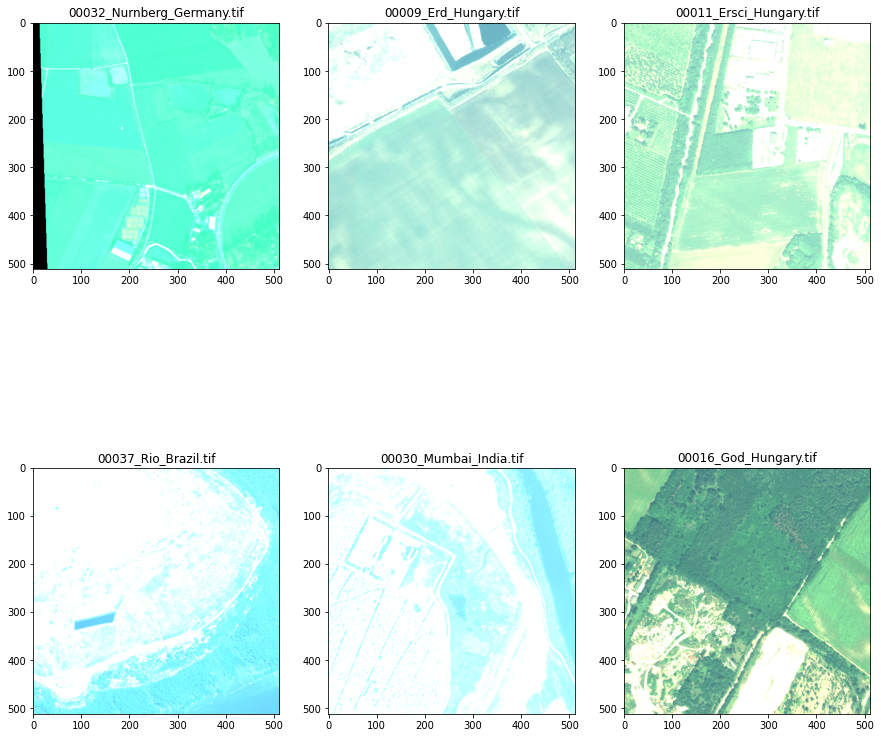

In [16]:
fig = plt.figure(figsize=(width, height))

img_info= next(iter(train_loader))
#print(img_info)

for idx in np.arange(batch_size):
  plt.subplot(2, 3, idx+1)
  id = img_info["image_id"][idx].item()
  name = img_info["image_name"][idx]
  channels = img_info["raster_channels"][idx].item()                         
  plt.imshow(im_convert(name, channels))
  plt.title(name)


Draw polygon on image:


In [19]:
json_frame = pd.read_csv(train_labels, usecols=["json index"])
json_list = json_frame.values.tolist()

for idx in np.arange(batch_size):
  id = img_info["image_id"][idx].item()
  json_name = json_list[id-1][0]
  gdf = gpd.read_file(os.path.join(json_path, json_name))
  print(gdf)

                                            geometry
0  POLYGON ((637227.578 5493738.042, 637260.503 5...
                                            geometry
0  POLYGON ((333716.920 5249386.288, 333716.007 5...
                                            geometry
0  POLYGON ((340912.374 5241765.080, 340913.284 5...
                                            geometry
0  POLYGON ((678710.728 7483507.961, 678710.728 7...
                                            geometry
0  POLYGON ((282854.580 2108840.857, 282845.546 2...
1                           GEOMETRYCOLLECTION EMPTY
2                           GEOMETRYCOLLECTION EMPTY
                                            geometry
0  POLYGON ((361511.462 5280080.949, 361898.367 5...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/usr/local/lib/python3.7/dist-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 2 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.f

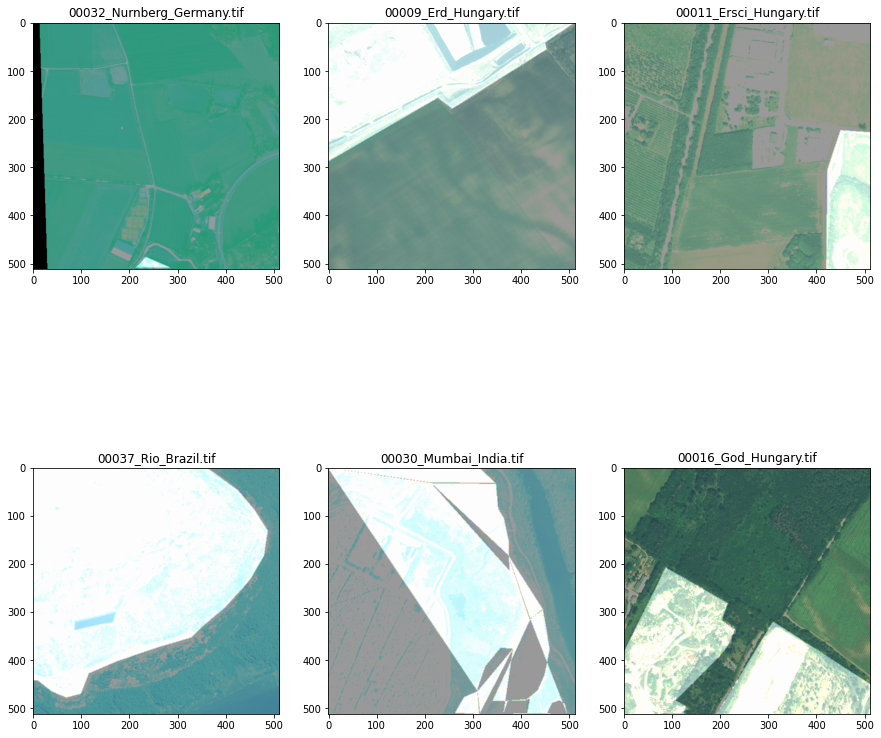

In [18]:
fig = plt.figure(figsize=(width, height))

for idx in np.arange(batch_size):
  plt.subplot(2, 3, idx+1)
  id = img_info["image_id"][idx].item()
  json_name = json_list[id-1][0]
  name = img_info["image_name"][idx]
  channels = img_info["raster_channels"][idx].item()  
  fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(json_path, json_name), reference_im=os.path.join(train_path, name))
  image = im_convert(name, channels)
  plt.imshow(image)
  plt.imshow(fp_mask, cmap='gist_earth', alpha=0.4)
  plt.title(name)

Custom transforms:\
https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html